<a href="https://colab.research.google.com/github/nlan082/BAINHOM/blob/main/detect_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
from keras.models import Sequential
from keras.layers import Dense
!pip install kagglehub
import kagglehub
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:

import kagglehub

# Download latest version
path = kagglehub.dataset_download("ppduyn/bt-3004")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/bt-3004


In [3]:

def load_dataset(folder_path, class_names, img_size=(64, 64)):
    X, y = [], []
    for label, class_name in enumerate(class_names):
        subfolder = os.path.join(folder_path, class_name)
        if not os.path.isdir(subfolder):
            print(f"Bỏ qua: {subfolder} không tồn tại")
            continue
        for fname in os.listdir(subfolder):
            if not fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            path = os.path.join(subfolder, fname)
            img = cv2.imread(path)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            X.append(img)
            y.append(label)
    return np.array(X), np.array(y)

In [4]:

path = '/kaggle/input/bt-3004/Nhận diện khuôn mặt'
class_names = ['Da Nguyet', 'Kim Tuyen', 'Ngoc Lan', 'Phuong Duyen', 'Thuy Linh','Thuy Vy','Tra My']
x, y = load_dataset(path, class_names)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train, x_test = x_train / 255.0, x_test / 255.0


In [5]:
model = Sequential([
    Flatten(input_shape=x_train.shape[1:]),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.1413 - loss: 6.8963 - val_accuracy: 0.2667 - val_loss: 2.5070
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2921 - loss: 2.0494 - val_accuracy: 0.3333 - val_loss: 1.7745
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4412 - loss: 1.5870 - val_accuracy: 0.3000 - val_loss: 1.6461
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.4497 - loss: 1.5454 - val_accuracy: 0.4667 - val_loss: 1.6887
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.4923 - loss: 1.4289 - val_accuracy: 0.5111 - val_loss: 1.6342
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.5777 - loss: 1.2428 - val_accuracy: 0.3444 - val_loss: 1.7292
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6360 - loss: 1.1563 - val_accuracy: 0.5111 - val_loss: 1.6520
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.5616 - loss: 1.1840 - val_accuracy: 0.3444 - v

In [7]:

model.save("face_cnn_model.h5")
with open("label_names.txt", "w") as f:
    for name in class_names:
        f.write(name + "\n")


In [8]:
!pip install mtcnn

In [9]:

!pip install --upgrade lz4
!pip install --upgrade joblib

In [17]:

from keras.preprocessing.image import img_to_array

In [18]:

from tensorflow.keras.models import load_model
from mtcnn.mtcnn import MTCNN
model = load_model('face_cnn_model.h5')
detector = MTCNN()
IMAGE_SIZE = 64
def preprocess_face(face_img):
    face_img = cv2.resize(face_img, (IMAGE_SIZE, IMAGE_SIZE))
    face_img = face_img.astype("float") / 255.0
    face_img = img_to_array(face_img)
    face_img = np.expand_dims(face_img, axis=0)
    return face_img

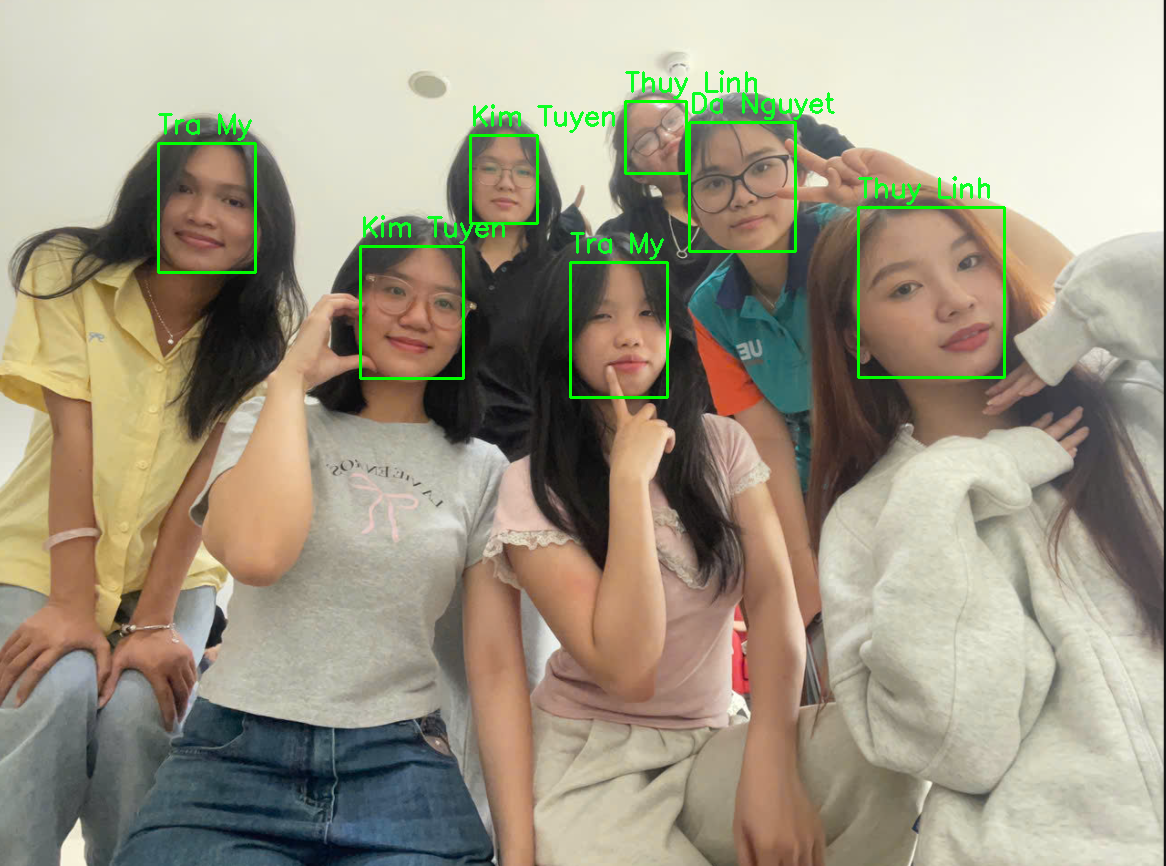

In [24]:
image_paths = [
    '/content/nhandien2.png'
]

for path in image_paths:
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)

    for result in results:
        x, y, w, h = result['box']
        x, y = max(0, x), max(0, y)
        face = img[y:y+h, x:x+w]

        try:
            processed = preprocess_face(face)
            prediction = model.predict(processed, verbose=0)[0]
            label_index = np.argmax(prediction)
            name = class_names[label_index]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(img, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        except Exception as e:
            print("Lỗi xử lý khuôn mặt:", e)

    from google.colab.patches import cv2_imshow
    cv2_imshow(img)



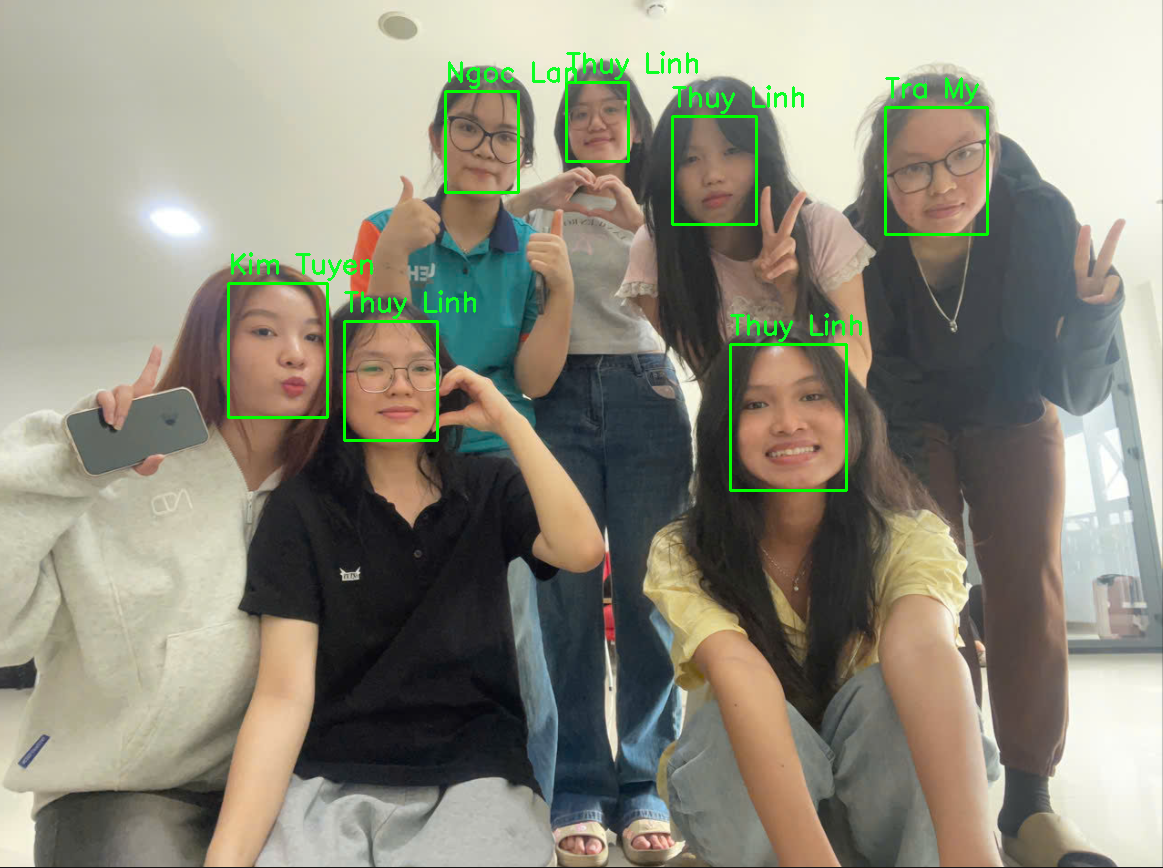

In [23]:
image_paths = [
    '/content/nhandien.png'
]

for path in image_paths:
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = detector.detect_faces(img_rgb)

    for result in results:
        x, y, w, h = result['box']
        x, y = max(0, x), max(0, y)
        face = img[y:y+h, x:x+w]

        try:
            processed = preprocess_face(face)
            prediction = model.predict(processed, verbose=0)[0]
            label_index = np.argmax(prediction)
            name = class_names[label_index]
            cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)
            cv2.putText(img, name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        except Exception as e:
            print("Lỗi xử lý khuôn mặt:", e)

    from google.colab.patches import cv2_imshow
    cv2_imshow(img)
